In [1]:
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected as fc
import gym
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
# define the gym environement
env          = gym.make('CartPole-v0')
input_shape  = env.observation_space.shape
num_actions  = env.action_space.n

/home/xinghua/installation/anaconda3/envs/dqn/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [3]:
def model_NN(inputs,output_num, scope, reuse=False):
    output = inputs
    with tf.variable_scope(scope, reuse=reuse):
        output = fc(output, 10, activation_fn=tf.nn.relu)
        output = fc(output, 10, activation_fn=tf.nn.relu)
        output = fc(output, output_num, activation_fn=None)
    return output
# parameter settings
gamma        = 0.95
learningrate = 0.001

## define the place holder
state     = tf.placeholder(tf.float32, [None] + list(input_shape))
state_new = tf.placeholder(tf.float32, [None] + list(input_shape))
action    = tf.placeholder(tf.int32, [None])
reward    = tf.placeholder(tf.float32, [None])
done      = tf.placeholder(tf.float32, [None])

global_vars = tf.GraphKeys.GLOBAL_VARIABLES
current_Q   = model_NN(state, num_actions, scope='Q_Net', reuse=tf.AUTO_REUSE)
target_Q    = model_NN(state_new, num_actions, scope='Target_Net', reuse=tf.AUTO_REUSE)
# obtain the weight for each scope
Q_net_W      = tf.get_collection(global_vars, scope='Q_Net')
Target_net_W = tf.get_collection(global_vars, scope='Target_Net')
# calculate the error
onehot_actions = tf.one_hot(action, num_actions, 1.0, 0.0)
target_Q_max   = tf.reduce_max(target_Q, axis=1)
q_target_val = reward + gamma * (1. - done) * target_Q_max
q_candidate_val = tf.reduce_sum(current_Q * onehot_actions, axis=1)
total_error = tf.reduce_sum(tf.square(q_target_val - q_candidate_val))
# define the optimizer
trainer = tf.train.AdamOptimizer(learning_rate=learningrate)
updateModel = trainer.minimize(total_error,var_list = Q_net_W)
# update_target_fn will be called periodically to copy Q network to target Q network
update_target_fn = []
for var, var_target in zip(sorted(Q_net_W, key=lambda v: v.name),
                           sorted(Target_net_W, key=lambda v: v.name)):
    update_target_fn.append(var_target.assign(var))
update_target_fn = tf.group(*update_target_fn)

tf_config = tf.ConfigProto(device_count = {'GPU': 0})
sess = tf.Session(config=tf_config)
sess.run(tf.global_variables_initializer())
merged_summary = tf.summary.merge_all()
writer = tf.summary.FileWriter("~/EDQN_replay/mountainCar/log")
writer.add_graph(sess.graph)

In [4]:
# start the Q learning process
frame_max          = int(1e6)
replay_buffer      = []
batch_size         = 64
State              = env.reset()
episilon           = 1
frames             = 0
learning_start     = int(1e3)
learning_frequency = 4
accumulated_reward = 0
target_update_frequency = int(1e4)
REWARD             = []
memory_max_length  = int(5e4)
episode_max_num    = int(5e3)
episilon_decay_rate= 0.99
episode            = 0
fifty_mean_reward  = []
fifty_mean_frames  = []
while episode < episode_max_num:
    # choose action
    if np.random.random() < episilon:
        Action = env.action_space.sample()
    else:
        Action = np.argmax(sess.run(current_Q,feed_dict={state:[State]}))
    # step in the environment and store the replay list
    State_new, Reward, Done, Info = env.step(Action)
    frames             +=  1
    accumulated_reward +=  Reward
    replay_list = [State,Action,Reward,State_new,Done]
    replay_buffer.append(replay_list)
    # update the surrent state
    if Done:
        State = env.reset()
        REWARD.append(accumulated_reward)
        accumulated_reward = 0
        episode += 1
    else:
        State = State_new
    # start the learning process
    if frames>learning_start and frames%learning_frequency==0:
        ## get the minibatch
        minibatch       = random.sample(replay_buffer, batch_size)
        state_batch     = [elem[0] for elem in minibatch]
        action_batch    = [elem[1] for elem in minibatch]
        reward_batch    = [elem[2] for elem in minibatch]
        state_new_batch = [elem[3] for elem in minibatch]
        done_batch      = [elem[4] for elem in minibatch]
        
        feed_diction = {state:state_batch, action:action_batch,reward:reward_batch, state_new:state_new_batch, done:done_batch}
        loss_val, _ = sess.run([total_error, updateModel], feed_dict=feed_diction)
#         s = sess.run(merged_summary)
#         writer.add_summary(loss_val,i)

    if len(replay_buffer)==memory_max_length:
        del replay_buffer[:5000]
        
    if frames % target_update_frequency == 0:
        sess.run(update_target_fn)
        
    if len(REWARD)>50 and frames%2000==0:
        fifty_mean_reward.append(np.mean(REWARD[-50:]))
        fifty_mean_frames.append(episode)
        print(np.mean(REWARD[-50:]))
        print(episode)
        
    if episode % 10==0:
        episilon *= episilon_decay_rate
    if episilon<=0.1:
        episilon=0.1
    
    
        

10.18
174
9.7
378
9.88
583
9.64
790
9.78
986
10.02
1187
9.98
1387
10.1
1585
10.24
1785
9.94
1987
10.46
2187
10.02
2387
9.6
2591
9.62
2792
12.76
2954
17.78
3076
19.62
3174
19.18
3274
18.6
3372
21.98
3464
24.06
3542
28.4
3614
30.74
3681
36.02
3736
47.88
3773
60.62
3806
69.86
3832
80.62
3856
90.38
3876
107.56
3891
122.62
3905
135.16
3919
139.88
3933
143.02
3946
150.58
3958
159.14
3970
167.86
3981
173.96
3992
178.48
4003
183.0
4013
187.82
4023
191.76
4033
194.2
4044
195.42
4054
193.44
4065
185.8
4077
176.28
4089
165.38
4103
152.26
4117
148.2
4130
146.84
4143
150.9
4156
155.3
4168
158.9
4181
160.82
4192
163.64
4205
161.08
4218
155.96
4232
152.94
4245
145.52
4259
146.9
4273
149.68
4285
150.36
4299
147.12
4313
156.08
4324
158.72
4336
164.42
4347
171.16
4359
179.0
4369
181.62
4379
188.56
4389
192.64
4399
197.86
4409
198.52
4419
199.52
4429
199.52
4439
199.52
4449
198.94
4459
198.24
4470
185.42
4483
178.84
4495
160.84
4509
159.46
4520
168.54
4530
172.06
4540
179.56
4551
189.3
4562
185.56
4574
1

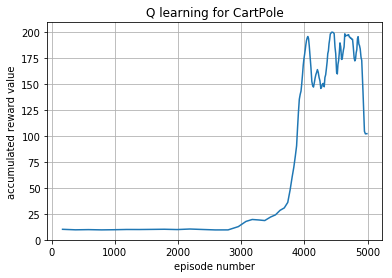

In [5]:
plt.plot(fifty_mean_frames, fifty_mean_reward)

plt.xlabel('episode number')
plt.ylabel('accumulated reward value')
plt.title('Q learning for CartPole')
plt.grid(True)
plt.savefig("Q learning for CartPole.png")
plt.show()